In [31]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

import sys
import skimage #scikit-learn image manipulation #
from skimage import io
import matplotlib.pyplot as plt #plot utilities #
import numpy as np #numerical computations #
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

# Part 1: Computing and analyzing the eigenspace
### Finding Local Manifold
This function takes an input for object selection named index_object and gives a matrix with all images into the matrix X. Dimension of X: (128*128,128). I keep an optional argument to the function named num_image (default value: 128) to load a dataset if it does not have exactly 128 images. In our case, local objects dataset contains 128 images with size 128x128 pixels.

In [32]:
def ImageLoadLocal(index_object, num_image = 128):
    """This function takes an input for object selection named index_object and gives a matrix with all
    images into the matrix X. Dimension of X: (128*128,128). I keep an optional argument to the function 
    named num_image (default value: 128) to load a dataset if it does not have exactly 128 images. 
    In our case, local objects dataset contains 128 images with size 128x128 pixels"""
    n = num_image
    obj = ['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
       'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash']
    X = np.zeros((n**2,0))
    for i in range(n):
        Img = io.imread('Data/TrainingImages/'+str(obj[index_object])+'64'+'/UnProcessed/img_'+str(i)+'.png', as_gray=True)
        Img = skimage.img_as_float32(Img).reshape(n**2,1)
        #Ivec = Img.reshape(128**2,1)
        X = np.hstack((X,Img))
    return X

The following function takes an image vector containing all images from an object (computed above) and calculates Basis vectors, and Singular values using "singular value decomposition (SVD)." The function gives eigenimages (Basis vectors), and normalized eigenvalues calculated from singular values. 

In [33]:
def BasisVectorLocal(image_vector):   
    """  Now that we have the Image data matrix (X), we need to compute the eigenvectors of 
    the sample covariance matrix (1/n * X * X^T), recall that we can efficiently do this
    via the Singular Value Decomposition.  We want to set "full_matrices = False" becasue
    we only care about the first 128 coluns of U (the remaining colums simply span the Nullspace of X)"""
    U,S,Vt = np.linalg.svd(image_vector,full_matrices=False)

    S = S**2
    Sf = S/sum(S)
    
    return U, Sf

In [34]:
def PlotImgLocal(num):
    """Plot one of the images in X just to be sure things look okay  """
    # plt.figure(1)
    plt.imshow(X[:,num].reshape(n,n), cmap='gray')
    plt.axis('off')

This function plots some eigenimages.

In [35]:
def PlotEigsLocal(U, n = 128):
    """  The "eigenimages"" are exactly the columns of U (they just need to be reshaped back to image format) """
    for i in range(8):
        plt.subplot(1,9,i+1)
        plt.axis('off')
        plt.imshow(U[:,i].reshape(n,n),cmap='gray')

The following function is written to illustrate 3 dimensional manifold of eigenimages. We are interested to make a descriptor (high-dimensional manifold) such that we are able to compare a test image later on and classify objects and estimate pose of the test image. The reason we plot 3D manifold here is, we can visualize 3D plots. If we select more than 3 dimensional Basis vector to calculate the manifold, we will not be able to plot manifold. However, we calculated neccesary dimensional manifold of both local image datasets and for global image dataset for pose estimation and classification. 

In [36]:
def Illustration3DLocal(U, X, k = 3):
    """  Next let's go ahead and compute the low-dimensional manifold by projecting
    the image data back down to a 3-dimensional subspace.

    Note 1:  You will likely need
    more than 3-dimensions for pose estimation - we just use 3-dimensions so we can 
    actually visualize what's going on here. 

    Note 2:  Each red dot corresponds to one of the images of object 1 in the low-dimenisonal subspace.
    For pose estimation, youd get a new test image, reshape it to a vector, compute p=U[:,0:k].T@Ivec
    where in this case, k would be the subspace dimension determined by the energy recovory ratio.
    p in this case will be a new k-dimensional point you can compare to each point on the manifold 
    (compute the distance between p and all the other points).  The closest point on the manifold to p will
    be the estimate of the pose."""
    k = 3 #subspace dimension for visualization
    M = U[:,0:k].T@X

    ax = plt.axes(projection='3d')
    ax.plot3D(M[0,:], M[1,:], M[2,:],'blue')
    ax.scatter3D(M[0,:], M[1,:], M[2,:],color='red')
    ax.set_title('Illustration of pose manifold in $\mathbb{R}^3$')
    ax.set_xlabel('$\phi_1$')
    ax.set_ylabel('$\phi_2$')
    ax.set_zlabel('$\phi_3$')

Simply, we need to keep first k number of Basis vectors from the matrix of eigenimages. The following function does that.

In [37]:
# I would like to keep first k basis vectors equivalent to at least 90% recovery ratio
def KeepFirstKLocal(Sf,E_ratio = 0.9):
    k = 0
    e_sum = 0
    while e_sum <= E_ratio:
        e_sum += Sf[k]
        k += 1
    final_k = k+1
    return final_k

We now are interested to see how many k's are necessary to get some desired performance for each object.

In [38]:
def AllKsLocal():
    obj = ['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
           'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash']
    objects = len(obj)
    K = np.zeros(objects)
    for i in range(objects):
        X = ImageLoadLocal(i)
        U,Sf = BasisVectorLocal(X)
        k = KeepFirstKLocal(Sf)
        K[i] = k
    return K

Plotting an image from first object dataset "Boat". Object dataset array are given below. In the following cell, num_object = 0 mean, it select first object from the array "obj". In cell below, we plot 50th image from Boat dataset.
obj = ['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
           'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash']

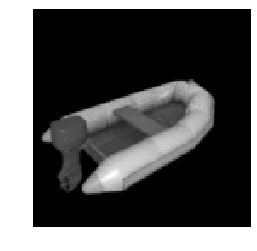

In [39]:
num_object = 0
n = 128
X = ImageLoadLocal(num_object)
PlotImgLocal(50)

Now we are interested to plot and see how eigenimages look like. We plot some eigenimages in the cell below. 

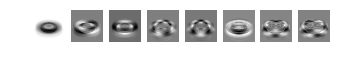

In [40]:
n = 128
# n = 128
obj = ['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
       'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash']
num_object = 0

X = ImageLoadLocal(num_object)
U,Sf = BasisVectorLocal(X)
PlotEigsLocal(U)

In the cell below, we show how many k's are necessary to achieve 90% cumulative value in the normalized squared singular values (eigenvalues). We know the first eigenvalue carry maximum weight and descending until last eigenvalue, which is zero. 

In [41]:
K = AllKsLocal()
print(K)

[ 8.  2.  5.  9.  4.  7.  7. 12.  7. 11. 14. 22.  3.  6. 16.  3. 13.  3.
  6.  2.]


### Finding Global maniflod
The following function loads all 128 images from all 20 objects in an array sized (128*128 x 20*128)

In [42]:
def LoadImage(n = 128):
    # loading all 20 objects datasets in a vector
    obj = ['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
           'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash']
    n_obj = len(obj)
    G = np.zeros((n**2,n*n_obj))
    for j in range(n_obj):
        for i in range(n):
            Img = io.imread('Data/TrainingImages/' + str(obj[j])+ '64' + '/UnProcessed/img_' + str(i) + '.png', as_gray = True)
            Img = skimage.img_as_float32(Img).reshape(n**2,1)
            #Ivec = Img.reshape(128**2,1)
    #         X[:,i,j] = Img
            G[:,128*j+i] = Img.T
    return G

We want to make sure everyting is right, just plotting an image from the entire jumbo vector G.

In [43]:
def PlotImg(num):
    # plotting an image to see if everything okay
    G = LoadImage()
    plt.imshow(G[:,num].reshape(n,n), cmap='gray')
    plt.axis('off')

Now we calculate Basis vectors (eigenimages) of the global dataset G

In [44]:
def BasisVector(G):
    Ug,Sg,Vtg = np.linalg.svd(G,full_matrices=False) 
    # Dimension of G: (128*128, 128*20)
    Sgg = Sg**2
    Sggf = Sgg/sum(Sgg)
    return Ug, Sggf

Want to plot some eigenimages from global eigenimages

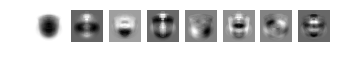

In [45]:
def PlotEigs():
    G = LoadImage()
    Ug, Sg = BasisVector(G)
    for i in range(8):
        plt.subplot(1,9,i+1)
        plt.axis('off')
        plt.imshow(Ug[:,i].reshape(n,n),cmap='gray')
PlotEigs()

Now, like local 3D illustration of manifold, we want to visualize global manifold in 3D taking k = 3.

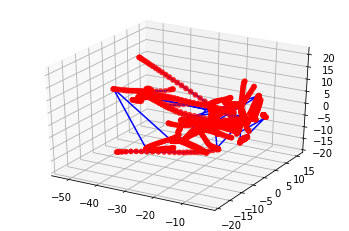

In [46]:
def Illustration3D(k = 3):
    G = LoadImage()
    Ug, Sg = BasisVector(G)
    M = Ug[:,0:k].T@G

    # fig = plt.figure(3)
    # fig.suptitle('Illustration of pose manifold in $\mathbb{R}^3$')
    ax = plt.axes(projection='3d')
    ax.plot3D(M[0,:], M[1,:], M[2,:],'blue')
    ax.scatter3D(M[0,:], M[1,:], M[2,:],color='red')
Illustration3D()

In [47]:
def K():
    G = LoadImage()
    Ug,Sf = BasisVector(G)
    k = KeepFirstKLocal(Sf)
    return k
k = K()
print(k)

36


## Explaination three Objects in 3D subspace

### Object 1: Boat
From the figure in 3D below, it is possible to distinguish each training images separately. So, with k = 3, boat dataset can be expressed in a subspace such that any test image can be classified and estimated pose of the test image with limited error.

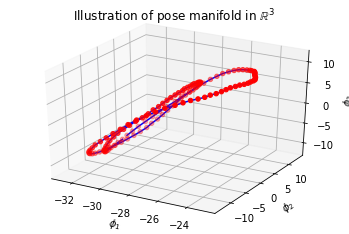

In [48]:
obj = ['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
       'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash']
num_object = 0

X = ImageLoadLocal(num_object)
U,Sf = BasisVectorLocal(X)

Illustration3DLocal(U, X)

### Object 2: Cabinet
Unlike Boat subspace in 3D, Cabinet subspace in 3D cannot be expressed robustly. So, pose estimation might be difficult (expect big error with k = 3) with k = 3 for Cabinet Dataset. 

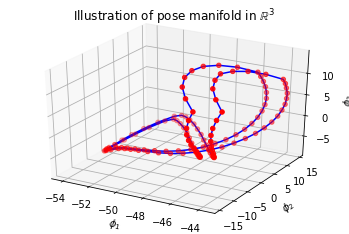

In [49]:
num_object = 1

X = ImageLoadLocal(num_object)
U,Sf = BasisVectorLocal(X)

Illustration3DLocal(U, X)

### Object - My choice: LED
I would like to see how difficult it is to estimate pose with k = 3 for LED dataset. It is very difficult for me actually to differentiate pose of LED dataset. So I am curious to see what happens.

From the figure below, we see that it is extremely difficult for us to distinguish each red points in 3D as red points are overlapped on other red points. This is what I expected. So, with k = 3, pose estimation will be almost impossible with minimal error. We will explore more in pose estimation section (part 3) later on and conclude how we get errors with different energy recovery ratio.

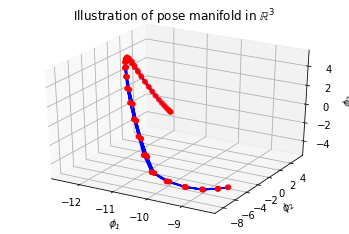

In [50]:
num_object = 12

X = ImageLoadLocal(num_object)
U,Sf = BasisVectorLocal(X)

Illustration3DLocal(U, X)

# Part 2: Computing the appropriate subspace dimension
The following function calculates Energy Ratio rho given image dataset matrix, Basis vector matrix, and k. K represents how many basis vectors (eigenimages) we want to keep. 

In [51]:
# energy recovery ratio
X = ImageLoadLocal(0)
U,Sf = BasisVectorLocal(X)

def ComputeER(X,U,k):
    rho = 0
    for j in range(k+1):
        Uk = U[:,0:j]
        num_f = 0
        for i in range(j):
            a = Uk[:,i].T@X
            num_f += (np.linalg.norm(a))**2
        den = (np.linalg.norm(X, 'fro'))**2
    rho += num_f/den
    return rho

Now we have a relationship with k and energy ratio. We are actually interested to find out how many k's are required to achieve certain given energy recovery ration. Energy recovery ratio can be given in range (0 ~ 1). However, we have seen that, finding k given energy recovery ratio more than 0.9 is computationally expensive. We have also seen that energy recovery ratio 0.8 gives pretty much accurate pose estimation and accurate classification for given dataset. 

In [52]:
def desiredER(percent,X,U):
    rho = 0
    k = 1
    while rho < percent:
        k += 1
        rho = ComputeER(X,U,k)
    return k, rho
k, rho = desiredER(0.9,X,U)

Generating values for k's for each objects and for three different energy recovery ratio. 

In [53]:
def tableER():
    obj = ['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
           'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash']
    objects = len(obj)
    desired_percents = [0.80,0.90,0.95]
    table = np.zeros((objects,len(desired_percents)))
    
    for ii in range(objects):
        X = ImageLoadLocal(ii)
        U,Sf = BasisVectorLocal(X)
        for jj in range(len(desired_percents)):
            perc = desired_percents[jj]
            k, rho = desiredER(perc,X,U)
            table[ii,jj] = k
    return table
table = tableER()
# print(table)

Generating a table that describes k's required for each objects for 3 different energy recovery ratio.

In [54]:
from IPython.display import HTML, display

obj = np.array(['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
           'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash'])
t = table.tolist()
d = []
per = ['Object\ER', '80%','90%','95%']
d.append(per)
for i in range(20):
    v = [obj[i],t[i][0],t[i][1],t[i][2]]
    d.append(v)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in d)
       )
))

Object\ER,80%,90%,95%
Boat,3.0,7.0,12.0
Cabinet,2.0,2.0,3.0
Car,3.0,4.0,10.0
Chair,4.0,8.0,16.0
Cup,2.0,3.0,5.0
Flashlight,3.0,6.0,12.0
Handle,4.0,6.0,10.0
HoseReel,5.0,11.0,19.0
ibook01,3.0,6.0,13.0
imac04,4.0,10.0,17.0


# Part 3: Object classification system

In [55]:
G = LoadImage()
Ug, Sg = BasisVector(G)

The following function finds out percentage error in degree for a test image given. steps:
1. select a test image from test dataset
2. select the actual radian angle of the selected test image from given file "RandAng.txt"
3. match the closest image from the global manifold using functions above
4. calculate pose of the closest image found in radian
5. calculate absolute radian angle between actual pose of test image and estimated pose of the matched image
6. calculate angle in degree

In [56]:
def FindError(test_img_index, object_index, desired_ER = 0.8):
    des_ER = desired_ER
    select_test_img = test_img_index
    index_obj = object_index
    
    if index_obj > 19:
        print('Invalid Object Selected. Range object is: 0 - 19')
        sys.exit()
    elif select_test_img > 31:
        print('Invalid Image Selected. Range of test image is: 0 - 31')
        sys.exit()
    
    k, rho = desiredER(des_ER,G,Ug)
    M = Ug[:,0:k-1].T@G

    # load a test image here
    obj = np.array(['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
               'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash'])
    g_te = io.imread('Data/TestImages/'+str(obj[index_obj])+'32'+
                     '/UnProcessed/img_'+str(select_test_img)+'.png', as_gray=True)
    test_image = g_te
    # process image
    g_test = skimage.img_as_float32(g_te).reshape(128**2,1)

    g_t = Ug[:,0:k-1].T@g_test
    error = np.zeros(2560)
    e_final = 1000
    for i in range(2560):
        e = np.linalg.norm(M[:,i] - g_t.T)
        error[i] = e
        if e < e_final:
            e_final = e
            ind = i
            
    i = int(ind % 128)
    index_object_found = int((ind - i)/128)
    obj_cls = obj[index_object_found]
    img_match = io.imread('Data/TrainingImages/'+str(obj[index_object_found])
                          +'64'+'/UnProcessed/img_'+str(i)+'.png',as_gray=True)
    
    # read RandAng.txt file
    with open('Data/TestImages/RandAng.txt', 'r') as f:
        l = [[float(num) for num in line.split(',')] for line in f]
    l = np.array(l)
    test_data = np.squeeze(l)

    # finding radian angle of the selected image -------> "select_test_img"
    test_angle_rad = test_data[select_test_img]
    
    # finding degree error here
    if index_object_found == index_obj:
        match = 1
    else: 
        no_match = 1
        print('Failed to Match Object')
        sys.exit
    if match == 1:
        est_rad = (2*np.pi*i)/128
        actual_rad = test_angle_rad
        rad_error = est_rad - actual_rad
        deg_error = abs((180/np.pi)*rad_error)
    return deg_error, img_match, test_image, obj_cls, actual_rad, est_rad, rad_error

## Classification and Pose Estimation

We want to print and see how error in degree look like for some test images. User can select any test image from any test object dataset. We also want to classify object here

In [57]:
obj = np.array(['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
           'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash'])

# select a test image index from 0 to 31
test_img_index = 31
# select an object from 0 to 19
object_index = 10
obj_sel = obj[object_index]
deg_error, img_match, test_image, obj_cls, actual_rad, est_rad, rad_error \
            = FindError(test_img_index, object_index, desired_ER = 0.8)

print('Object Selected: ' + str(obj_sel))
print('Object Classified: ' + str(obj_cls))
print('Actual Orientation of Selected Test Image in Radian: ' + str(actual_rad))
print('Estimated Orientation of Matched Image in Radian: ' + str(est_rad))
print('Error in Radian (absolute value): ' + str(abs(rad_error)))

Object Selected: imac98
Object Classified: imac98
Actual Orientation of Selected Test Image in Radian: 4.4687
Estimated Orientation of Matched Image in Radian: 4.466952054322987
Error in Radian (absolute value): 0.0017479456770130852


Now we want to see both test image given and closest match side by side. 

Text(0.5, -1e-06, 'Pose Estimation')

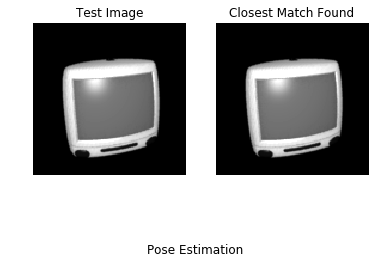

In [58]:
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(test_image, cmap = 'gray')
ax1.axis('off')
ax2.imshow(img_match, cmap = 'gray')
ax2.axis('off')

ax1.set_title("Test Image")
ax2.set_title("Closest Match Found")
fig1.suptitle('Pose Estimation', y=-0.000001)

Now we want to see average error in percentage degree for all test images of an object. The following function exactly does that.

In [59]:
# finding average error of all images of an object 
# select an object from 0 to 19
def percentDegError(object_index, desired_ER):
    total_deg_error = 0
    for i in range(32):
        deg_error, img_match, test_image, obj_cls, actual_rad, est_rad, rad_error = FindError(i, object_index, desired_ER)
        total_deg_error += deg_error
    avg_deg_error = total_deg_error/32
    percent_error = (avg_deg_error*100)/360
    return percent_error

In [60]:
object_index = 18
desired_ER = 0.7
percent_error = percentDegError(object_index, desired_ER)
print(percent_error)

0.3421650065721797


Now we want to evaluate percentage average degree error (performance) for all datasets and for 3 different energy ratio. We want to see how performance varies with respect to energy ratio. ERs in the cell below is the array of different energy ratio to be evaluated.

## Disclaimer: Computation for energy recovery ratio takes a lot of time especially for ER > 0.8. The below cell might take more than 1 hour to execute depending on configuration of computer

## My recommendation is not to run this cell. I loaded data that the following cell generates and read in the next cell.

In [ ]:
ERs = [0.7,0.75,0.8]
# ERs = [0.7,0.75]
Output = np.zeros((20,len(ERs)))
for i in range(20):
    for j in range(len(ERs)):
        percent_error = percentDegError(i, ERs[j])
        Output[i,j] = percent_error
#     time.sleep(1)
#     print(i)
# print(Output)

## As the above cell takes a lot of time to execute. I saved data to a txt file. I am reading data from that txt file instead of running the above cell over and over again.

In [62]:
with open('Test1.txt', 'r') as f:
    l = [[float(num) for num in line.split(' ')] for line in f]
l = np.array(l)
l = np.squeeze(l)
l.resize(20,3)
Output = np.array(l)

We are interested to plot a bar graph for all objects in different energy ratio.

<Figure size 432x288 with 0 Axes>

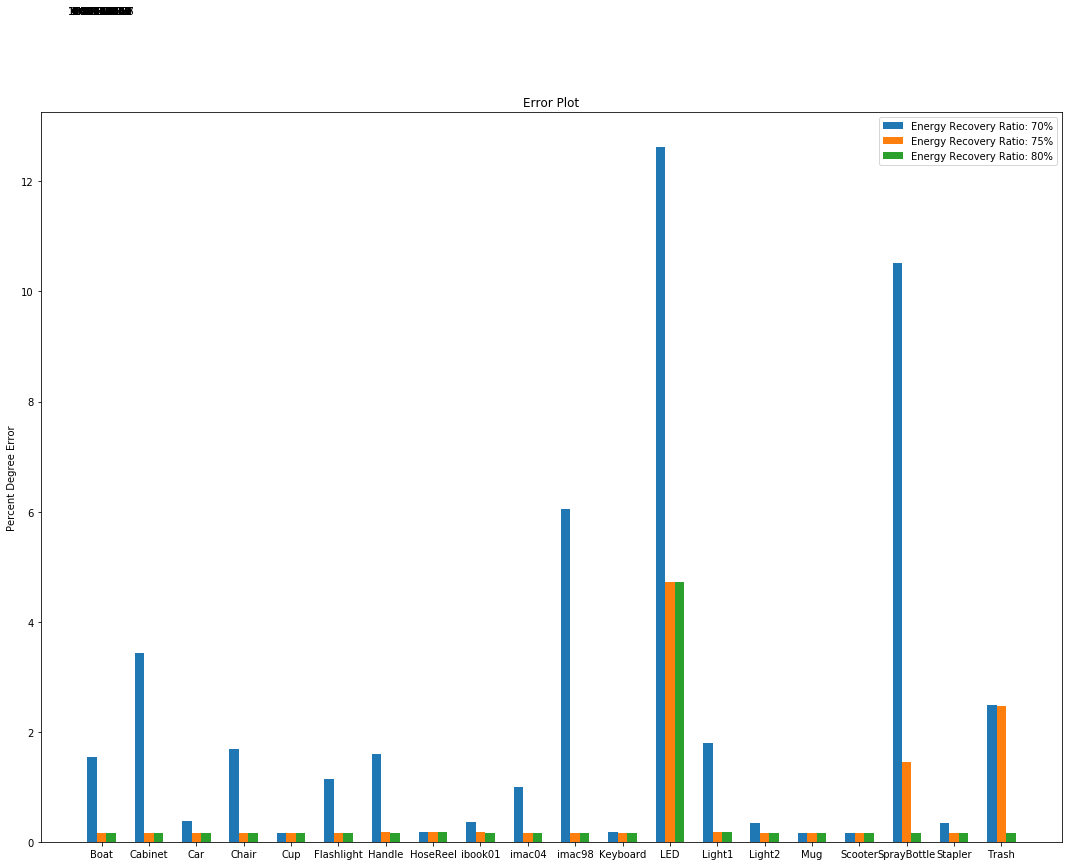

In [63]:
import matplotlib
plt.clf()
labels = ['Boat','Cabinet','Car','Chair','Cup','Flashlight','Handle','HoseReel','ibook01','imac04',
               'imac98','Keyboard','LED','Light1','Light2','Mug','Scooter','SprayBottle','Stapler','Trash']

ER70 = Output[:,0].T
ER80 = Output[:,1].T
ER90 = Output[:,2].T

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,12))
rects1 = ax.bar(x - width, ER70, width, label='Energy Recovery Ratio: 70%')
rects2 = ax.bar(x, ER80, width, label='Energy Recovery Ratio: 75%')
rects3 = ax.bar(x + width, ER90, width, label='Energy Recovery Ratio: 80%')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent Degree Error')
ax.set_title('Error Plot')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 15),  # 3 points vertical offset
#                     textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

### Discussion on bar graph:
We expect that with the increase of energy recovery ration, percentage degree error goes down. The bar graph reflects with energy recovery ration 80%, all objects show significant reduction in average percentage degree error except LED data. The reason is, finding out orientation of LED is very difficult. From most of the closest angles, LED looks pretty much similar. 
Technically speaking, LED dataset need more eigenimages compared to other datasets to accurately evaluate pose estimation. 

In [360]:
# with open("Test.txt", 'a') as myfile:
#     myfile.write(', '.join(str(item) for item in Output)+'\n')